In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
# CONSTANTES
BATCH_SIZE = 48
IMG_SIZE = 32
NUM_CLASSES = 10  # nº classes para identificar
NUM_EPOCHS = 60
LEARNING_RATE = 0.001
DROPOUT_RATES = [0.3, 0.5, 0.5]

In [3]:
# Folders do dataset
train_dirs = ['./dataset/train/train1', './dataset/train/train2', './dataset/train/train3', './dataset/train/train5']
validation_dir = './dataset/validation'
test_dir = './dataset/test'

In [4]:
# CRIAR OS GERADORES
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# training generators
train_generators = [train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical') for train_dir in train_dirs]

# Necessário para junstar os trainning generators
def combined_generator(generators):
    while True:
        for generator in generators:
            yield next(generator)

train_generator = combined_generator(train_generators)

# Validation e test generators
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

Found 10000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.


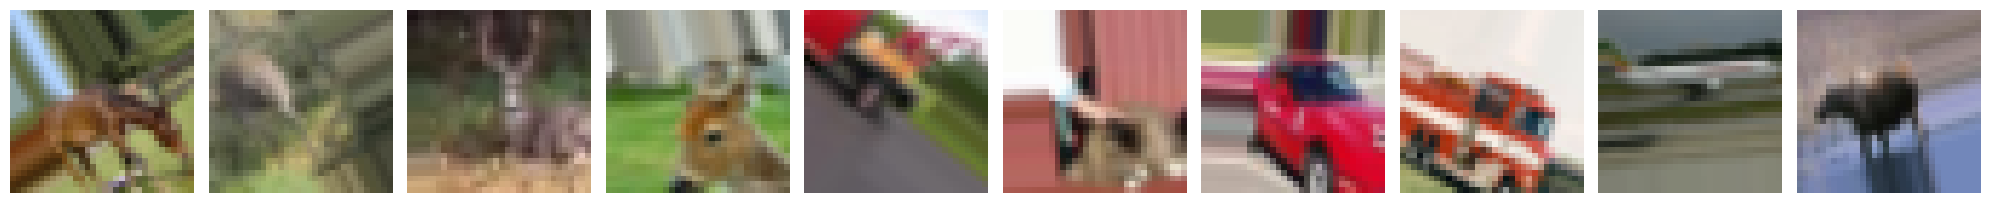

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 256)       7168      
                                                                 
 batch_normalization (BatchN  (None, 30, 30, 256)      1024      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 30, 30, 256)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 256)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 15, 15, 256)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 512)       1

In [5]:
# Function to plot images
def plot_images(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    #plt.savefig('./plot.png')
    plt.show()

# Generate a batch of images and display them
sample_batch = next(train_generator)
plot_images(sample_batch[0][:10])# Definir as layers do modelo
model = Sequential([
    Conv2D(256, (3, 3), input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(DROPOUT_RATES[0]),
    
    Conv2D(512, (3, 3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(DROPOUT_RATES[1]),
    
    Conv2D(1024, (3, 3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dense(1024),
    BatchNormalization(),
    Activation('relu'),
    Dropout(DROPOUT_RATES[2]),
    
    Dense(NUM_CLASSES, activation='softmax')
])

# Compilar o modelo
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

In [6]:
# CALLBACKS
checkpoint = ModelCheckpoint("best_model.keras", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

csv_logger = CSVLogger('logs/main_batch_48_2.csv', separator=',', append=False)

In [7]:
# calcular passos por epoch
steps_per_epoch = sum([gen.samples // BATCH_SIZE for gen in train_generators])

# Treinar o modelo - Nao tirar os callbacks
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=NUM_EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=[checkpoint, early_stopping, csv_logger]
)

# Avaliar o modelo no test generator
loss, accuracy = model.evaluate(test_generator)
print("Test Accuracy:", accuracy)

Epoch 1/30
832/832 [==============================] - ETA: 0s - loss: 2.0580 - accuracy: 0.2874
Epoch 1: val_accuracy improved from -inf to 0.36448, saving model to best_model.keras
832/832 [==============================] - 125s 137ms/step - loss: 2.0580 - accuracy: 0.2874 - val_loss: 1.7559 - val_accuracy: 0.3645
Epoch 2/30
831/832 [============================>.] - ETA: 0s - loss: 1.7495 - accuracy: 0.3703
Epoch 2: val_accuracy improved from 0.36448 to 0.38482, saving model to best_model.keras
832/832 [==============================] - 54s 65ms/step - loss: 1.7494 - accuracy: 0.3703 - val_loss: 1.9372 - val_accuracy: 0.3848
Epoch 3/30
832/832 [==============================] - ETA: 0s - loss: 1.6123 - accuracy: 0.4184
Epoch 3: val_accuracy improved from 0.38482 to 0.42488, saving model to best_model.keras
832/832 [==============================] - 51s 61ms/step - loss: 1.6123 - accuracy: 0.4184 - val_loss: 1.6073 - val_accuracy: 0.4249
Epoch 4/30
831/832 [===========================

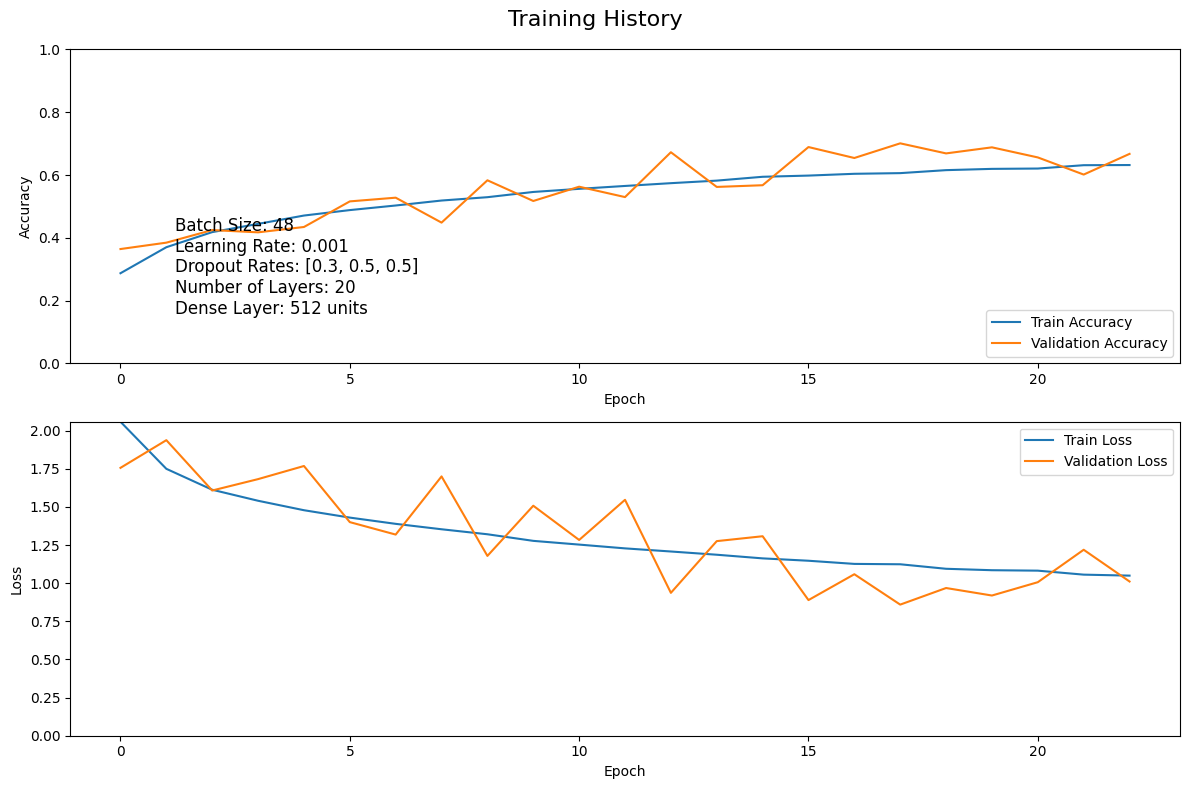

209/209 [==============================] - 3s 15ms/step - loss: 0.8406 - accuracy: 0.7072
Test Accuracy: 0.7071999907493591


In [8]:
# Save the plot of training history
def plot_training_history(history, batch_size, output_base_dir='./plots'):
    output_dir = f"{output_base_dir}/batch_size_{batch_size}"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    plt.figure(figsize=(12, 8))
    
    # Plot accuracy
    plt.subplot(2, 1, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')
    
    # Plot loss
    plt.subplot(2, 1, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim([0, max(history.history['loss'])])
    plt.legend(loc='upper right')

    # Add titles and text box with parameters
    plt.suptitle('Training History', fontsize=16)
    textstr = '\n'.join((
        f'Batch Size: {batch_size}',
        f'Learning Rate: {LEARNING_RATE}',
        f'Dropout Rates: {DROPOUT_RATES}',
        f'Number of Layers: {len(model.layers)}',
        f'Dense Layer: 512 units'))
    
    plt.gcf().text(0.15, 0.6, textstr, fontsize=12)
    
    # Save the plot
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'training_history.png'))
    plt.show()

# Plot and save the training history
plot_training_history(history, BATCH_SIZE)

# Avaliar o modelo no test generator
loss, accuracy = model.evaluate(test_generator)
print("Test Accuracy:", accuracy)